In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from math import *
import csv
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from pandas import concat
from pandas import DataFrame

from math import sqrt
from numpy import concatenate


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [57]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [58]:
dataPath = "project\data\FinalData.csv"
data = pd.read_csv(dataPath)
# data=data.iloc[:,2:4]
data=data.iloc[:,2:39]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)
reframed = series_to_supervised(scaled, 1, 1)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var28(t),var29(t),var30(t),var31(t),var32(t),var33(t),var34(t),var35(t),var36(t),var37(t)
1,0.162162,0.15625,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.616935,0.622549,0.625000,0.378049,0.378049,0.413333,0.055172
2,0.108108,0.21875,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.782258,0.740196,0.775000,0.524390,0.524390,0.533333,0.082759
3,0.135135,0.18750,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.770161,0.730392,0.764286,0.548780,0.548780,0.582222,0.124138
4,0.243243,0.18750,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.790323,0.750000,0.717857,0.451220,0.451220,0.542222,0.089655
5,0.162162,0.21875,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.745968,0.705882,0.692857,0.426829,0.426829,0.595556,0.020690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2744,0.459459,0.62500,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.012097,0.014706,0.010714,0.158537,0.158537,0.066667,0.275862
2745,0.513514,0.56250,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.008065,0.009804,0.014286,0.158537,0.158537,0.084444,0.186207
2746,0.432432,0.62500,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.016129,0.014706,0.021429,0.170732,0.170732,0.088889,0.206897
2747,0.486486,0.62500,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.056452,0.029412,0.046429,0.158537,0.158537,0.124444,0.310345


In [59]:
values = reframed.values
n_train_hours = 365*2
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-37], train[:, -37:]  
test_X, test_y = test[:, :-37], test[:, -37:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(730, 1, 37) (730, 37) (2018, 1, 37) (2018, 37)


Epoch 1/100
15/15 - 2s - loss: 0.1856 - val_loss: 0.1794 - 2s/epoch - 129ms/step
Epoch 2/100
15/15 - 0s - loss: 0.1588 - val_loss: 0.1679 - 98ms/epoch - 7ms/step
Epoch 3/100
15/15 - 0s - loss: 0.1349 - val_loss: 0.1581 - 91ms/epoch - 6ms/step
Epoch 4/100
15/15 - 0s - loss: 0.1177 - val_loss: 0.1538 - 103ms/epoch - 7ms/step
Epoch 5/100
15/15 - 0s - loss: 0.1053 - val_loss: 0.1534 - 100ms/epoch - 7ms/step
Epoch 6/100
15/15 - 0s - loss: 0.0940 - val_loss: 0.1553 - 115ms/epoch - 8ms/step
Epoch 7/100
15/15 - 0s - loss: 0.0842 - val_loss: 0.1581 - 114ms/epoch - 8ms/step
Epoch 8/100
15/15 - 0s - loss: 0.0815 - val_loss: 0.1578 - 80ms/epoch - 5ms/step
Epoch 9/100
15/15 - 0s - loss: 0.0801 - val_loss: 0.1558 - 82ms/epoch - 5ms/step
Epoch 10/100
15/15 - 0s - loss: 0.0787 - val_loss: 0.1542 - 84ms/epoch - 6ms/step
Epoch 11/100
15/15 - 0s - loss: 0.0776 - val_loss: 0.1530 - 79ms/epoch - 5ms/step
Epoch 12/100
15/15 - 0s - loss: 0.0765 - val_loss: 0.1519 - 87ms/epoch - 6ms/step
Epoch 13/100
15/15 - 

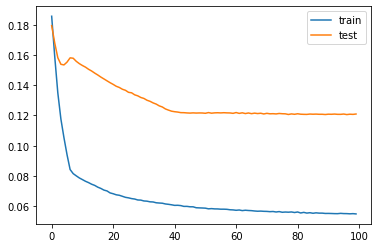

Test RMSE: 23.433
R²: -0.019026038989817196


In [60]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(37))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
yhat = scaler.inverse_transform(yhat)
test_y = scaler.inverse_transform(test_y)
# calculate RMSE
rmse = sqrt(mean_squared_error(test_X, yhat))
print('Test RMSE: %.3f' % rmse)
print("R²:",r2_score(test_y,yhat))